# Travel Behavior
The purpose of this notebook is to better explore indiviudal travel behavior by parsing through individual tag IDs of high frequency users. From this analysis, it's clear that individuals are not as regular as we think, or at least "regular commuters" are a lot smaller piece of HOV users. 

In [1]:
library(ggplot2)
library(RSQLCipher)
library(data.table)
suppressMessages(library(lubridate))
suppressMessages(library(tidyverse))
options(repr.plot.width=4, repr.plot.height=4)

In [2]:
Sys.setenv("SQL_KEY"=Sys.getenv("HOT_KEY"))
db_path = "../../../db/hot-v3.db"
trips_2pct <- load_table(db_path, "trips_2pct")
trips_linked <- load_table(db_path, "trips_linked")

In [3]:
reliability = suppressMessages(read_csv("../../data/benefits/expected_reliability_savings.csv"))
trip_length_lookup = suppressMessages(read_csv("../../data/milepost_lookups/trip_length_lookup.csv"))
m_est_values = suppressMessages(read_csv("../../data/benefits/est_vot_vor_elast.csv"))
time_savings = suppressMessages(read_csv("../../../data/concatenated_405_travel_times_5am_to_8pm_5_min.csv"))
trips_gate_time = suppressMessages(read_csv("../../data/benefits/trips_gate_time.csv"))

In [4]:
head(trips_gate_time)
nrow(trips_gate_time)

date_time,entry,exit,tod,toll,mean_inc,GP_volume,HOT_volume,GP_speed,HOT_speed,count,savings
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1514873280,13,14,608,0.75,80675.36,59.78182,20.14545,60,60,1,0.00900000
1514873280,13,17,608,0.75,101309.02,59.78182,20.14545,60,60,8,0.06802778
1514873280,13,18,608,0.75,80791.27,59.78182,20.14545,60,60,4,0.06786111
1514873280,13,20,608,0.75,108937.05,59.78182,20.14545,60,60,4,0.06802778
1514873280,13,22,608,0.75,79371.64,59.78182,20.14545,60,60,5,0.06802778
1514873280,13,23,608,0.75,128948.82,59.78182,20.14545,60,60,3,0.06802778


[1] 174940

In [5]:
trip_sample <- trips_2pct %>%
    execute

Warning message:
“12 parsing failures.
  row col expected actual         file
23087 zip a double v7b1k7 literal data
32084 zip a double V3W7X4 literal data
69739 zip a double V3W7X4 literal data
75337 zip a double V3W7X4 literal data
87441 zip a double V3W7X4 literal data
..... ... ........ ...... ............
See problems(...) for more details.
”

## Identifying Individual Behavior

In [6]:
id_trips <- trips_linked %>%
    filter(!is.na(id)) %>%
    group_by(id) %>%
    summarize(total_trips = n()) %>%
    filter(total_trips > 150,
          total_trips < 500) %>%
    select(id, total_trips) %>%
    execute

In [7]:
creeper_view <- function(id_num) {
    id_test <- id_trips$id[id_num]
    trips_id_test <- trips_linked %>%
        filter(as.numeric(id) == id_test) %>%
        execute
    
    trips_id_test$entry_time <- (round(as.numeric(trips_id_test$entry_time) / 600.0)) * 600
    trips_id_test$entry_time <- as_datetime(trips_id_test$entry_time, tz = "UTC")
    trips_id_test$hour_min <- format(as.POSIXct(trips_id_test$entry_time),"%H%M" )
    
    tags <- trips_id_test %>%
        group_by(tag_id) %>%
        summarize()
    
    plot_tag <- function(tag_num) {
        tag_id_match <- tags$tag_id[tag_num]
        trips_tag <- trips_id_test %>%
            filter(tag_id == tag_id_match)
        ggplot(trips_tag, aes(x = hour_min)) +
            geom_histogram(stat = "count", bin_width = 10) 
    }     
    
    lapply(1:nrow(tags), plot_tag)
}

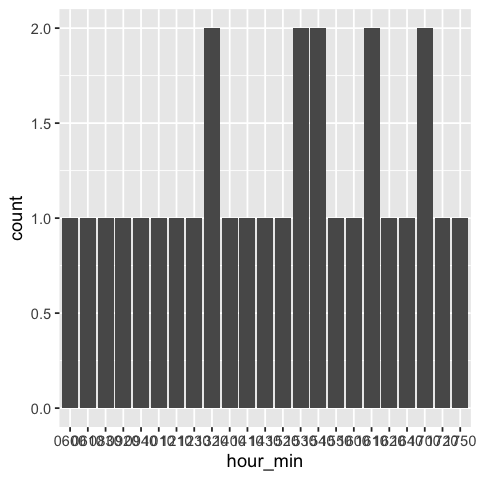

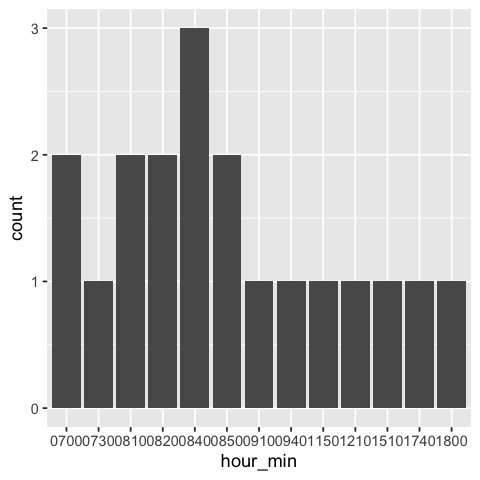

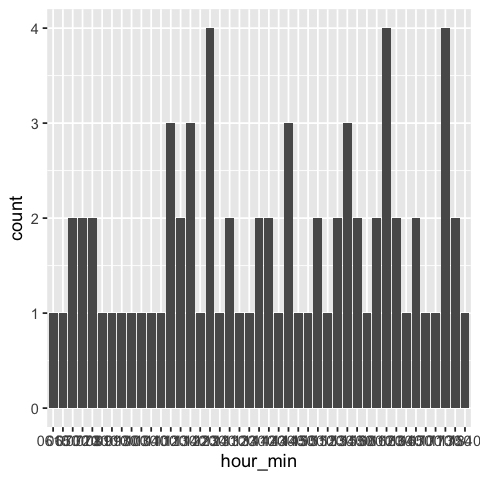

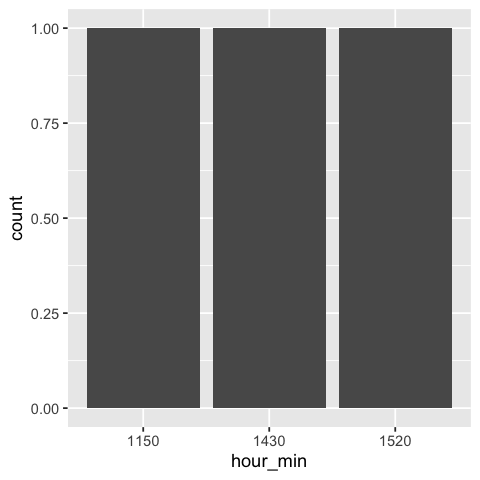

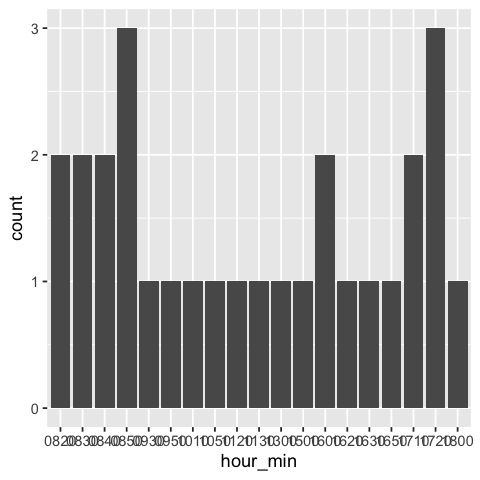

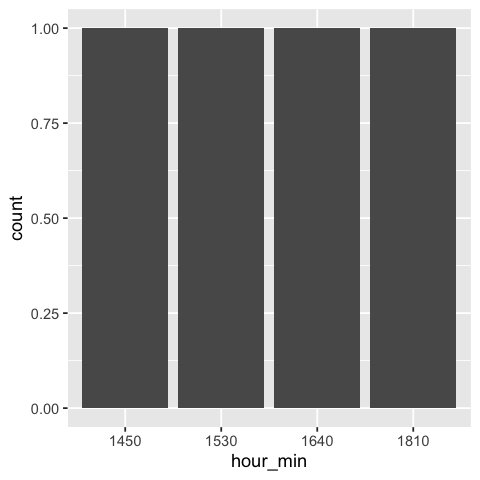

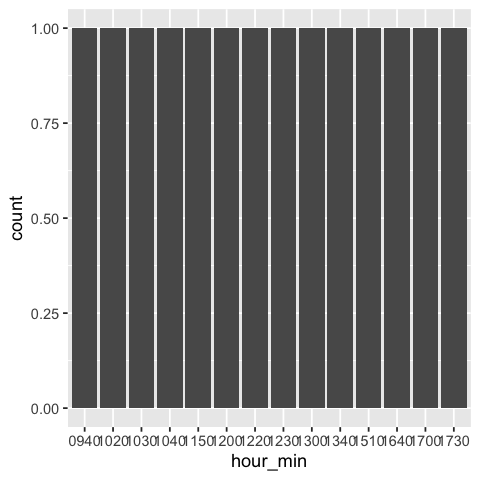

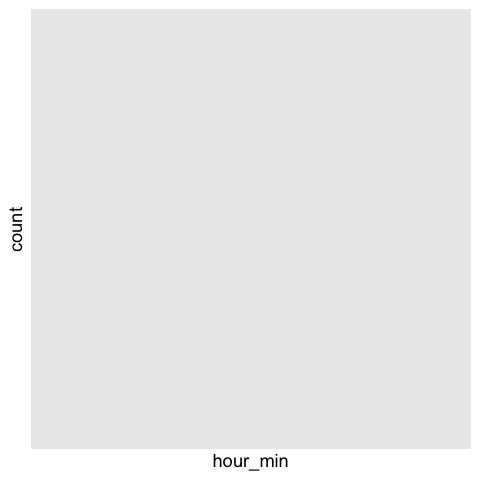

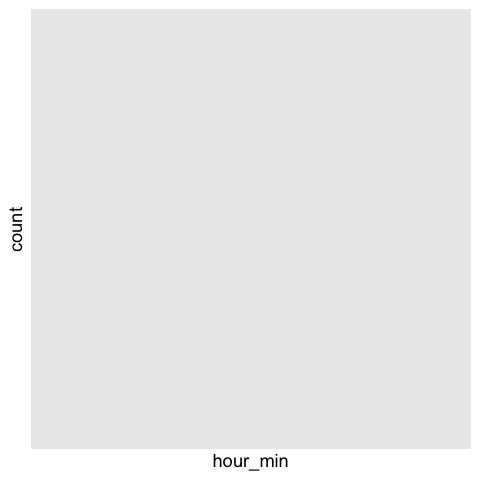

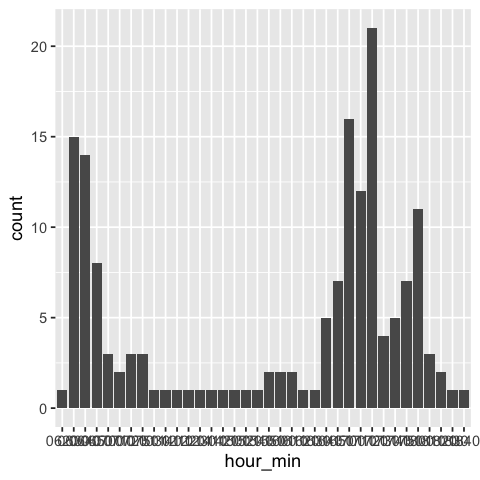

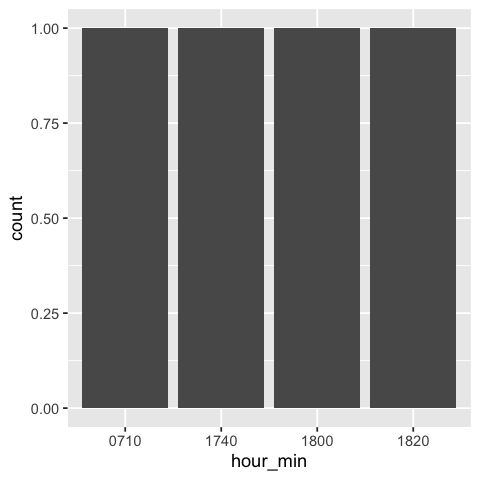

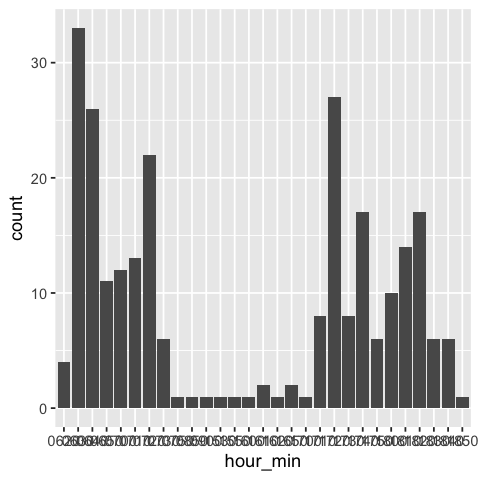

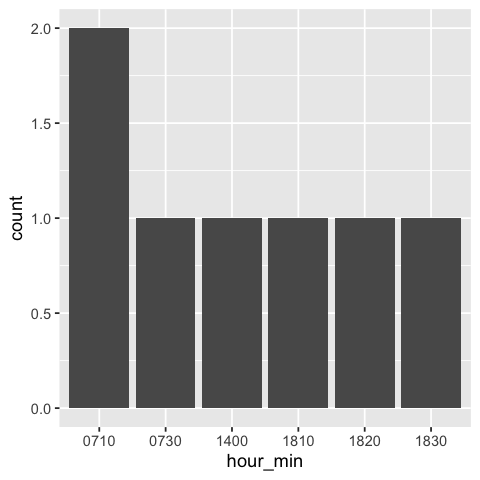

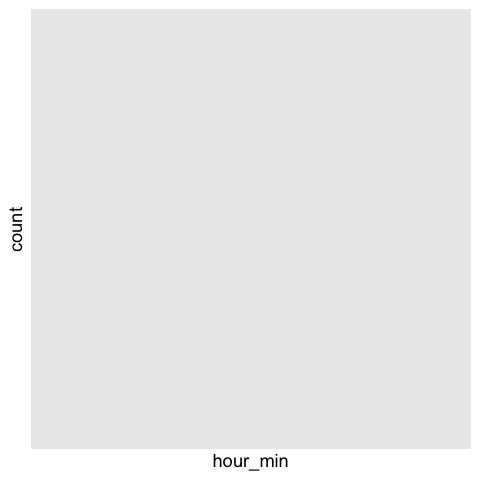

[[1]]
[[1]][[1]]

[[1]][[2]]

[[1]][[3]]

[[1]][[4]]

[[1]][[5]]

[[1]][[6]]

[[1]][[7]]

[[1]][[8]]


[[2]]
[[2]][[1]]


[[3]]
[[3]][[1]]

[[3]][[2]]

[[3]][[3]]

[[3]][[4]]

[[3]][[5]]


[[4]]
[[4]][[1]]

[[4]][[2]]



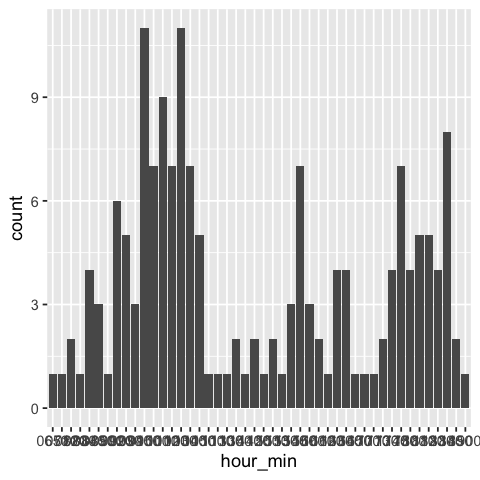

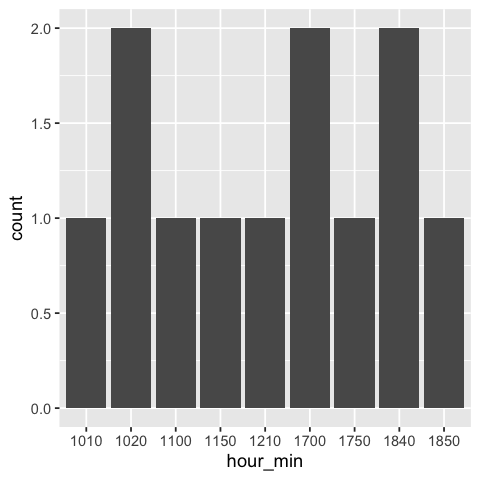

In [8]:
suppressWarnings(lapply(1:4, creeper_view))

## Travel Behavior for Regular Commuters
Identifying regular commuters and quantifying how "regular" their usage is - can be applied to different income groups?


### Rounding to 30 Minute Intervals and Raw Counts of Trips

In [9]:
#get list of ID's

id_list <- trips_linked %>%
    filter(!is.na(id)) %>%
    group_by(id) %>%
    summarize(total_trips = n()) %>%
    filter(total_trips > 100) %>%
    select(id) %>%
    execute

In [10]:
id_list_2pct <- trips_2pct %>%
    filter(!is.na(id)) %>%
    filter(total_trips > 100,
          commercial == 0) %>%
    group_by(id) %>%
    summarize() %>%
    select(id) %>%
    arrange(id) %>%
    execute

In [11]:
regular_users <- tibble(regular = 0, non_regular = 0)

regular <- as.integer(0)
non_regular <- as.integer(0)

getmodefreq <- function(v) {
    uniqv <- unique(v)
    max(tabulate(match(v, uniqv)))
}

commuter_count <- function(id_num) {
    id_match <- id_list_2pct$id[id_num]
    
    # create dataframe of an ID's trips
    id_trips <- trips_linked %>%
        filter(as.numeric(id) == id_match) %>%
        execute

    # convert to time of day, round to 20 minute intervals
    id_trips$entry_time <- (floor(as.numeric(id_trips$entry_time) / 1800.0)) * 1800
    id_trips$entry_time <- as_datetime(id_trips$entry_time, tz = "UTC")
    id_trips$hour_min <- format(as.POSIXct(id_trips$entry_time),"%H%M" )
    
    # get list of tags
    tags <- id_trips %>%
        filter(!is.na(tag_id)) %>%
        group_by(tag_id) %>%
        summarize() 
    
    # parse a tag's trips and assign a user regular or not regular
    tag_trips <- function(tag_num) {
        tag_id_match <- tags$tag_id[tag_num]
        trips_tag <- id_trips %>%
            filter(tag_id == tag_id_match)
        # requirements for being "regular", trip entry time occurs more than 100 times
        if (getmodefreq(as.vector(trips_tag$hour_min)) > 50) {
            regular <<- regular + 1
        } else {
            non_regular <<- non_regular + 1
        }
    }
    
    if (nrow(tags) != 0) {
        lapply(1:nrow(tags), tag_trips)
    }
}

In [12]:
invisible(suppressWarnings(lapply(1:25, commuter_count)))
print(regular)
print(non_regular)

[1] 7
[1] 40


Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”

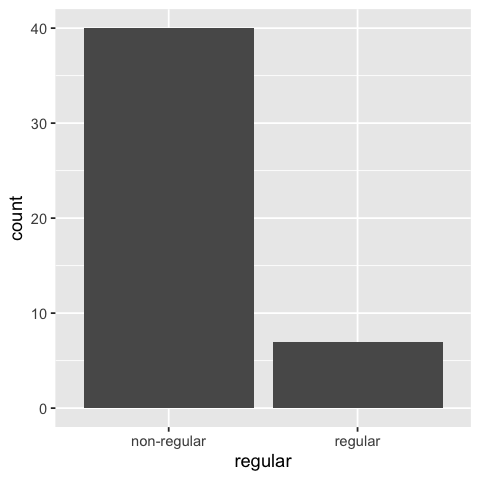

In [13]:
tribble(
    ~ regular, ~count,
    "regular", regular, 
    "non-regular", non_regular) %>%
ggplot(aes(x = regular, y = count)) + 
    geom_histogram(stat = "identity")

### Rounding to 30 Minute Intervals and Proportions

In [15]:
test_list <- list(proportion = NA)
regular_freq <- as.integer(0)
non_regular_freq <- as.integer(0)

getmodefreq <- function(v) {
    uniqv <- unique(v)
    max(tabulate(match(v, uniqv)))
}

commuter_freq_count <- function(id_num) {
    id_match <- id_list_2pct$id[id_num]
    
    # create dataframe of an ID's trips
    id_trips <- trips_linked %>%
        filter(as.numeric(id) == id_match) %>%
        execute

    # convert to time of day, round to 30 minute intervals
    id_trips$rounded_entry_time <- (round(as.numeric(id_trips$entry_time) / 1800.0)) * 1800
    id_trips$rounded_entry_time <- as_datetime(id_trips$rounded_entry_time, tz = "UTC")
    id_trips$rounded_hour_min <- format(as.POSIXct(id_trips$rounded_entry_time),"%H%M")
    
    # get list of tags that have more than 10 trips before 1pm
    tags <- id_trips %>%
        filter(!is.na(tag_id),
              rounded_hour_min > 1400) %>%
        group_by(tag_id) %>%
        summarize(total_trips = n()) %>% 
        filter(total_trips > 10)
    
    # parse a tag's trips
    tag_trip_freq <- function(tag_num) {
        #get tag id
        tag_id_match <- tags$tag_id[tag_num]
        
        #get tag trips based off of selected id before 9am
        trips_tag <- id_trips %>%
            filter(!is.na(tag_id),
            tag_id == tag_id_match,
                  rounded_hour_min > 1400)
        
        #get total trips based off of selected id before 9am
        total_tag_trips <- trips_tag %>%
            group_by(tag_id) %>%
            summarize(total_trips = n()) 

        test <- list(getmodefreq(as.vector(trips_tag$rounded_hour_min)) / total_tag_trips$total_trips[1])
                
        test_list <<- rbindlist(list(test_list, test), use.names = TRUE)
        
        # requirements for being "regular"; proportion of trips within most common 30 minute segment of total trips is greater than 75%
        if (test > .75) {
            regular_freq <<- regular_freq + 1
        } else {
            non_regular_freq <<- non_regular_freq + 1
        }
    }
    
    if (nrow(tags) != 0) {
        lapply(1:nrow(tags), tag_trip_freq)
    }
}

In [16]:
invisible(lapply(1:25, commuter_freq_count))
print(regular_freq)
print(non_regular_freq)

[1] 0
[1] 31


Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”

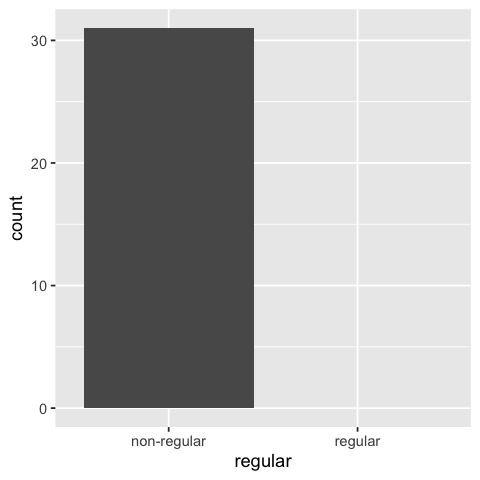

In [17]:
tribble(
    ~ regular, ~count,
    "regular", regular_freq, 
    "non-regular", non_regular_freq) %>%
ggplot(aes(x = regular, y = count)) + 
    geom_histogram(stat = "identity")

Warning message:
“Ignoring unknown parameters: bin_width”`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 1 rows containing non-finite values (stat_bin).”

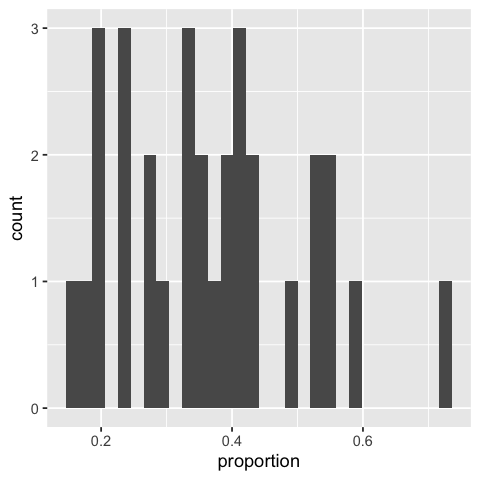

In [18]:
as.data.frame(test_list) %>%
ggplot() + 
    geom_histogram(aes(x = proportion), bin_width = 10) 

### Commute Direction and Time
The distribution below shows how many trips made in peak morning commutes were southbound - we should expect to see a bimondal distribution here with the ends being high. This would indicate that people were regularly going one direction in the morning, but with a proportion of .5, which direction that person is commuting is essentially a coin flip.

In [19]:
test_list <- list(proportion = NA)
regular_direction<- as.integer(0)
non_regular_direction <- as.integer(0)

getmodefreq <- function(v) {
    uniqv <- unique(v)
    max(tabulate(match(v, uniqv)))
}

commuter_direction_count <- function(id_num) {
    id_match <- id_list_2pct$id[id_num]

    # create dataframe of an ID's trips
    id_trips <- trips_linked %>%
        filter(as.numeric(id) == id_match) %>%
        execute

    # convert to time of day
    id_trips$entry_time <- as_datetime(id_trips$entry_time, tz = "UTC")
    id_trips$hour_min <- format(as.POSIXct(id_trips$entry_time),"%H%M")
    
    # get list of tags that have more than 10 trips before 9am
    tags <- id_trips %>%
        filter(!is.na(tag_id),
              hour_min < 900) %>%
        group_by(tag_id) %>%
        summarize(total_trips = n()) %>% 
        filter(total_trips > 10)
    
    # parse a tag's trips
    tag_trip_direction <- function(tag_num) {
        #get tag id
        tag_id_match <- tags$tag_id[tag_num]

        #get tag trips based off of selected id before 9am and going southbound
        trips_tag <- id_trips %>%
            filter(!is.na(tag_id),
                   tag_id == tag_id_match,
                  hour_min < 900,
                  entry_plaza >= 13)

        #get total trips based off of selected id before 9am 
        total_tag_trips <- id_trips %>%
            filter(!is.na(tag_id),
                  tag_id == tag_id_match,
                  hour_min < 900) %>%
            group_by(tag_id) %>%
            summarize(total_trips = n()) 
   
        test <- list(nrow(trips_tag) / total_tag_trips$total_trips[1])
                
        test_list <<- rbindlist(list(test_list, test), use.names = TRUE)
        
        # requirements for being "regular"; proportion of trips within most common 30 minute segment of total trips is greater than 75%
        if (test > .90) {
            regular_direction <<- regular_direction + 1
        } else {
            non_regular_direction <<- non_regular_direction + 1
        }
    }
    
    if (nrow(tags) != 0) {
        lapply(1:nrow(tags), tag_trip_direction)
    }
}

In [25]:
invisible(lapply(1:200, commuter_direction_count))
print(regular_direction)
print(non_regular_direction)

[1] 31
[1] 398


Warning message:
“Ignoring unknown parameters: bin_width”`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 1 rows containing non-finite values (stat_bin).”

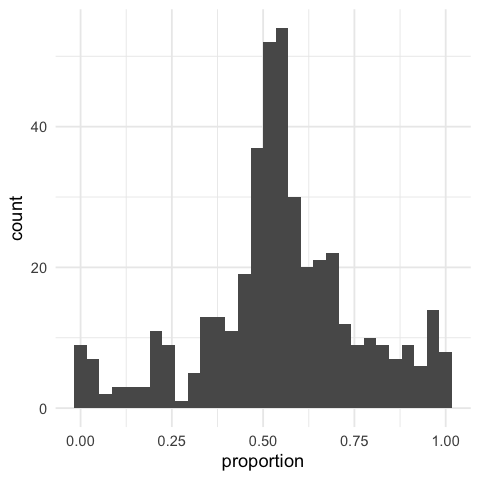

In [26]:
as.data.frame(test_list) %>%
ggplot() + 
    geom_histogram(aes(x = proportion), bin_width = 10) + 
    theme_minimal()